In [1]:
import numpy as np
import umap
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from product_space_wrapped_normal import ProductSpace

C:\Users\jiaze\anaconda3\envs\uml_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperbolic space is computed using Poincaré ball model
def hyperbolic_distance(x, y, c=1.0):
    xy_inner = torch.sum(x * y, dim=-1)
    x_norm_sq = torch.sum(x**2, dim=-1)
    y_norm_sq = torch.sum(y**2, dim=-1)
    num = 2 * (x_norm_sq + y_norm_sq - 2 * xy_inner)
    denom = (1 - c * x_norm_sq) * (1 - c * y_norm_sq)
    return torch.arccosh(1 + num / denom).numpy()

# Spherical spaces is computed using spherical distance
def spherical_distance(x, y):
    dot_product = np.clip(np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)), -1.0, 1.0)
    return np.arccos(dot_product)

def mixed_curvature_distance(point_a, point_b, component_types):
    # component_types is a list describing which space each component belongs to
    distance = 0.0
    for i, component_type in enumerate(component_types):
        if component_type == "euclidean":
            distance += np.linalg.norm(point_a[i] - point_b[i])
        elif component_type == "hyperbolic":
            distance += hyperbolic_distance(torch.tensor(point_a[i]), torch.tensor(point_b[i]))
        elif component_type == "spherical":
            distance += spherical_distance(point_a[i], point_b[i])
    return distance

In [3]:
# Wrapper to apply UMAP on mixed curvature product spaces
class UMAPMixedCurvature:
    def __init__(self, n_neighbors=15, min_dist=0.1, n_components=2, metric=None):
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components = n_components
        self.metric = metric
        self.umap_model = None

    def fit_transform(self, X, component_types):
        # Define a custom metric that incorporates mixed curvature distance
        if self.metric is None:
            metric = lambda a, b: mixed_curvature_distance(a, b, component_types)
        else:
            metric = self.metric
        
        # Standardize the Euclidean component for normalization purposes
        scaler = StandardScaler()
        for i, comp_type in enumerate(component_types):
            if comp_type == "euclidean":
                X[:, i] = scaler.fit_transform(X[:, i].reshape(-1, 1)).flatten()
        
        # Apply UMAP
        self.umap_model = umap.UMAP(
            n_neighbors=self.n_neighbors,
            min_dist=self.min_dist,
            n_components=self.n_components,
            metric=metric
        )
        return self.umap_model.fit_transform(X)

C:\Users\jiaze\anaconda3\envs\uml_project\lib\site-packages\umap\umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


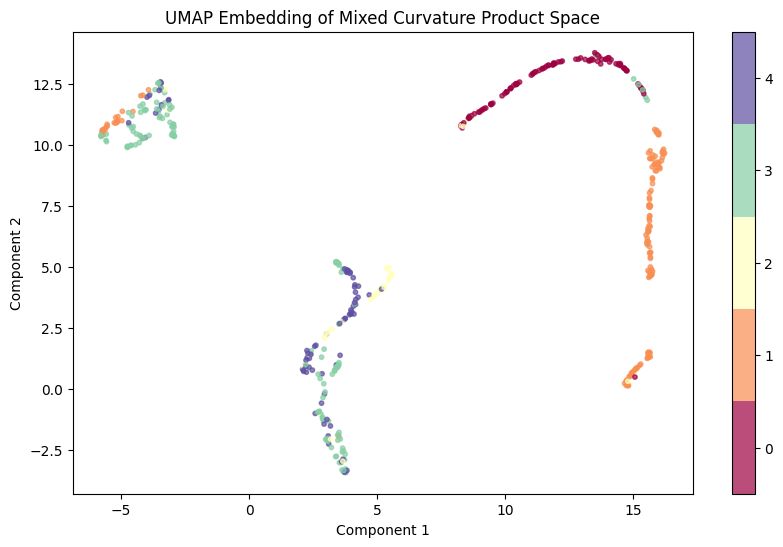

In [4]:
# Generate data using the ProductSpace class from the newly attached file
product_space = ProductSpace(signature=[(3, -1.0), (3, 0.0), (3, 1.0)])
n_samples = 500
n_classes = 5
product_space.sample_clusters(
    num_points=n_samples,
    num_classes=n_classes
)

# Flatten each data point for mixed-curvature distance calculation
X_flattened = np.array([np.concatenate([comp.flatten() for comp in x]) for x in product_space.X])

# Instantiate UMAP for mixed curvature spaces and fit-transform the data
umap_mixed = UMAPMixedCurvature(n_neighbors=15, min_dist=0.1, n_components=2)
component_types = ["hyperbolic", "hyperbolic", "euclidean", "euclidean"]
X_embedded = umap_mixed.fit_transform(X_flattened, component_types)

# Visualization of the embedded data
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=product_space.y, cmap='Spectral', s=10, alpha=0.7)
plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP Embedding of Mixed Curvature Product Space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

C:\Users\jiaze\anaconda3\envs\uml_project\lib\site-packages\umap\umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


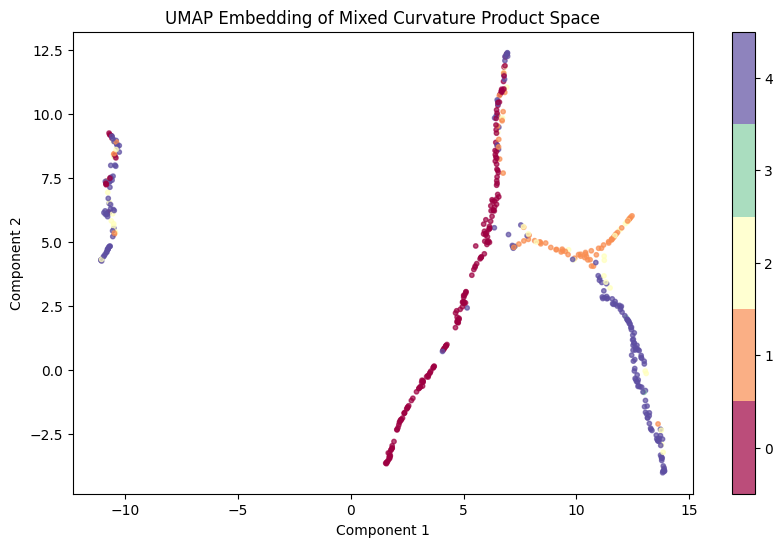

In [5]:
# Generate data using the ProductSpace class from the newly attached file
product_space = ProductSpace(signature=[(5, -1.0)])
n_samples = 500
n_classes = 5
product_space.sample_clusters(
    num_points=n_samples,
    num_classes=n_classes
)

# Flatten each data point for mixed-curvature distance calculation
X_flattened = np.array([np.concatenate([comp.flatten() for comp in x]) for x in product_space.X])

# Instantiate UMAP for mixed curvature spaces and fit-transform the data
umap_mixed = UMAPMixedCurvature(n_neighbors=15, min_dist=0.1, n_components=2)
component_types = ["hyperbolic", "hyperbolic", "euclidean", "euclidean"]
X_embedded = umap_mixed.fit_transform(X_flattened, component_types)

# Visualization of the embedded data
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=product_space.y, cmap='Spectral', s=10, alpha=0.7)
plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP Embedding of Mixed Curvature Product Space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()